# Final Project 6조 - 수산물 가격 예측

## [데이터 분석을 통한 시계열 예측 모델 구현과 서비스화]
- 데이터 전처리
- 모델 구현(fbProphet 시계열 예측 모델)
- 모델 성능평가
- API형태 배포

Renewal: 2021-10-31

### 1. 계절적 특성을 가지는 데이터의 시계열 예측에 효율적인 fbProphet 모델을 활용한 다차원 시계열 분석
- 범주별 fbProphet 적용 예시
- 다차원 시계열 분석 진행시 add regressor 문제: encoding 함수 생성으로 해결
- <제조국: 중국, 수출국: 중국, 수입용도: 판매용, 수입형태: 냉동>의 경우를 예시로 잡아 모델적용

### 2. 분석 결과를 자율평가 데이터셋과 비교해 모델의 성능평가 진행
- 자율평가 dataset과의 비교를 위해 데이터 전처리 후 merge

### 3. 분석결과 수입가격의 예측값 시각화
- 실제 데이터와 예측 데이터의 그래프 비교

Made by: 안동근

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import datetime
import warnings
warnings.filterwarnings("ignore")

## Column Index

REG_DATE(기준일) P_TYPE(제품구분) CTRY_1(제조국) CTRY_2(수출국) P_PURPOSE(수입용도)

CATEGORY_1(중분류명 카테고리) CATAGORY_2(어종) P_NAME(상세어종) P_IMPORT_TYPE(수입형태) P_PRICE(평균단가($))

In [2]:
train_data=pd.read_excel("train_data.xlsx")  # 학습데이터셋 불러오기
print(train_data.shape)
train_data.head(10)

(42073, 10)


,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,수산물,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000
1,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000
2,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352
3,2015-12-28,수산물,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870
4,2015-12-28,수산물,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340
5,2015-12-28,수산물,중국,중국,판매용,어류,복어,은밀복,냉동,2.167951
6,2015-12-28,수산물,중국,중국,판매용,어류,옥돔,옥돔,냉동,5.145111
7,2015-12-28,수산물,중국,중국,판매용,어류,복어,까치복,냉동,4.265697
8,2015-12-28,수산물,중국,중국,판매용,갑각류,새우,흰다리새우,"냉동,살,자숙",7.202863
9,2015-12-28,수산물,중국,중국,판매용,갑각류,새우,흰다리새우,"냉동,살",6.972132


In [3]:
train_data['P_TYPE'].unique()

array(['수산물'], dtype=object)

- P_TYPE은 단일 범주이므로 제외

In [4]:
# 필요한 col만 가져온다
train_data=train_data.loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME', 'P_IMPORT_TYPE', 'P_PRICE']]

- P_NAME(상세어종)이 구분 기준일 경우 CATEGORY_1과 CATEGORY_2는 구분대상에서 제외해도 된다고 판단

In [5]:
# 상세어종이 오징어, 연어, 흰다리새우 인경우로만 dataframe 생성
df1=train_data[train_data.P_NAME=='오징어'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]
df2=train_data[train_data.P_NAME=='연어'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]
df3=train_data[train_data.P_NAME=='흰다리새우'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]

### '상세어종: 오징어' 를 예시로 수입가격 예측을 진행

In [6]:
# P_NAME=오징어 df의 인덱스 수정 (Label Encoding전 전처리)
df1.reset_index(inplace=True)
df1.drop(columns='index', inplace=True)
print(df1.shape)
df1.head(10)

(2150, 6)


,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,대만,대만,판매용,"냉동,동체",1.989999
1,2015-12-28,중국,중국,판매용,"냉동,동체",0.793729
2,2015-12-28,페루,페루,판매용,"냉동,다리",1.233434
3,2015-12-28,페루,페루,판매용,"냉동,동체,자숙",5.481140
4,2015-12-28,칠레,칠레,판매용,"냉동,다리",0.968083
5,2015-12-28,칠레,칠레,판매용,"냉동,지느러미",0.762758
6,2015-12-28,칠레,칠레,판매용,"냉동,동체",0.962386
7,2016-01-04,칠레,칠레,판매용,"냉동,다리",0.945644
8,2016-01-04,페루,페루,판매용,"냉동,지느러미",0.600000
9,2016-01-04,페루,페루,자사제품제조용,"냉동,동체,자숙",3.716541


## Label Encoding

In [7]:
train=pd.DataFrame()
train['REG_DATE']=df1['REG_DATE']

for i in df1.columns[1:5]:          # Train Data Set : Label Encoding of category of column indices
    item_label=list(df1[i])
    encoder = LabelEncoder()
    encoder.fit(item_label)
    digit_label = encoder.transform(item_label)
    
    globals()['{}_decoded'.format(i)]=[]
    for j in item_label:
        if j not in globals()['{}_decoded'.format(i)]:
            globals()['{}_decoded'.format(i)].append(j)
        
    globals()['{}_encoded'.format(i)]=[]
    for j in digit_label:
        if j not in globals()['{}_encoded'.format(i)]:
            globals()['{}_encoded'.format(i)].append(j)

    print(i, 'Label Encoding 결과 최대 digit:', digit_label.max(), '\n')
    print('*'*50)
    train[i]=pd.Series(digit_label)
    
train['P_PRICE']=df1['P_PRICE']

CTRY_1 Label Encoding 결과 최대 digit: 14 

**************************************************
CTRY_2 Label Encoding 결과 최대 digit: 16 

**************************************************
P_PURPOSE Label Encoding 결과 최대 digit: 3 

**************************************************
P_IMPORT_TYPE Label Encoding 결과 최대 digit: 12 

**************************************************


- 아래와 같은 인코딩 내용 저장을 통해 성능평가와 예측결과 도출에서 수월할 수 있게한다.

>df1의 범주형 데이터가 numeric form으로 인코딩 되어 train에 저장되어있다

In [8]:
df1.head()

,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,대만,대만,판매용,"냉동,동체",1.989999
1,2015-12-28,중국,중국,판매용,"냉동,동체",0.793729
2,2015-12-28,페루,페루,판매용,"냉동,다리",1.233434
3,2015-12-28,페루,페루,판매용,"냉동,동체,자숙",5.481140
4,2015-12-28,칠레,칠레,판매용,"냉동,다리",0.968083


In [9]:
train.head()

,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,2,2,3,5,1.989999
1,2015-12-28,12,13,3,5,0.793729
2,2015-12-28,14,16,3,3,1.233434
3,2015-12-28,14,16,3,6,5.481140
4,2015-12-28,13,14,3,3,0.968083


예) 생산국 '중국'은 CTRY_1 = 12 로 인코딩

In [10]:
CTRY_1_decoded.index('중국')

1

In [11]:
CTRY_1_encoded[1]

12

In [12]:
# encoding의 input과 output수를 체크해 데이터 누락이 없는지 확인
len(CTRY_1_encoded), len(CTRY_1_decoded), len(CTRY_2_encoded), len(CTRY_2_decoded), len(P_PURPOSE_encoded), len(P_PURPOSE_decoded), len(P_IMPORT_TYPE_encoded), len(P_IMPORT_TYPE_decoded)

(15, 15, 17, 17, 4, 4, 13, 13)

In [13]:
def encoding_to_num():
    x1=input('제조국을 입력하세요: ')
    y1=CTRY_1_encoded[CTRY_1_decoded.index(x1)]
    
    x2=input('수출국을 입력하세요: ')
    y2=CTRY_2_encoded[CTRY_2_decoded.index(x2)]
    
    x3=input('수입용도를 입력하세요: ')
    y3=P_PURPOSE_encoded[P_PURPOSE_decoded.index(x3)]
    
    x4=input('수입형태를 입력하세요: ')
    y4=P_IMPORT_TYPE_encoded[P_IMPORT_TYPE_decoded.index(x4)]
    
    result=[y1,y2,y3,y4]
    print('\n인코딩 결과 => 제조국:{} -> {}, 수출국:{} -> {}, 수입용도:{} -> {}, 수입형태:{} -> {}'.format(x1,y1,x2,y2,x3,y3,x4,y4))
    return result

In [14]:
option=encoding_to_num()

제조국을 입력하세요: 중국
수출국을 입력하세요: 중국
수입용도를 입력하세요: 판매용
수입형태를 입력하세요: 냉동

인코딩 결과 => 제조국:중국 -> 12, 수출국:중국 -> 13, 수입용도:판매용 -> 3, 수입형태:냉동 -> 1


In [15]:
# option = [12, 13, 3, 1]
# 제조국:중국, 수출국:중국, 수입용도:판매용, 수입형태:냉동의 데이터 옵션이 저장되어있다.

In [16]:
df=train.loc[:, ['REG_DATE', 'P_PRICE']]
df.rename(columns={'REG_DATE':'ds','P_PRICE':'y'}, inplace=True)

df['CTRY_1']=train['CTRY_1']
df['CTRY_2']=train['CTRY_2']
df['P_PURPOSE']=train['P_PURPOSE']
df['P_IMPORT_TYPE']=train['P_IMPORT_TYPE']

In [17]:
m = Prophet()

# standardize option = True 일 경우 정규화된다
# Label Encoding된 데이터 이므로 False로 지정
# mode: seasonality_mode (default)
m.add_regressor('CTRY_1', standardize=False)
m.add_regressor('CTRY_2', standardize=False)
m.add_regressor('P_PURPOSE', standardize=False)
m.add_regressor('P_IMPORT_TYPE', standardize=False)

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


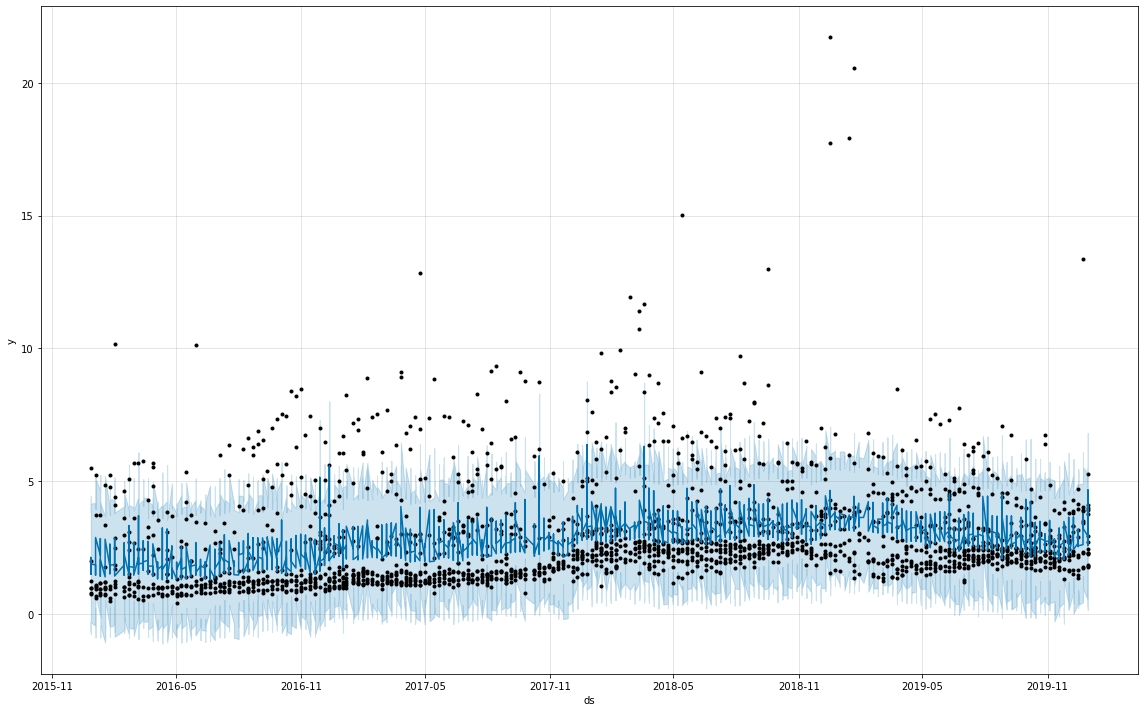

In [18]:
forecast=m.predict(df.drop(columns='y'))
fig1=m.plot(forecast, figsize=(16,10))

## 주(Week) 단위로 Future Dataframe 생성

In [19]:
N=52
# N = 52 : valid_data의 기간까지 나온다
future = m.make_future_dataframe(periods=N, freq='w')

In [20]:
future += datetime.timedelta(days=1)
future.tail()

,ds
255,2020-11-30
256,2020-12-07
257,2020-12-14
258,2020-12-21
259,2020-12-28


In [21]:
# option = [12, 13, 3, 1]
# 제조국:중국, 수출국:중국, 수입용도:판매용, 수입형태:냉동의 데이터 옵션이 저장되어있다.

In [22]:
# add regressor to future dataframe(apply option)

j=0
for i in option:
    future[list(train.columns[1:5])[j]]=i
    j+=1
    
future.tail()

,ds,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE
255,2020-11-30,12,13,3,1
256,2020-12-07,12,13,3,1
257,2020-12-14,12,13,3,1
258,2020-12-21,12,13,3,1
259,2020-12-28,12,13,3,1


In [23]:
forecast_sample=m.predict(future)

In [24]:
forecast_sample.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CTRY_1,CTRY_1_lower,CTRY_1_upper,CTRY_2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
255,2020-11-30,3.543341,-0.124124,4.480613,3.432546,3.645699,-0.720273,-0.720273,-0.720273,1.120832,...,0.826744,0.826744,0.826744,-0.142925,-0.142925,-0.142925,0.0,0.0,0.0,2.191147
256,2020-12-07,3.531592,0.041143,4.659871,3.417608,3.639019,-0.720273,-0.720273,-0.720273,1.120832,...,0.826744,0.826744,0.826744,0.068645,0.068645,0.068645,0.0,0.0,0.0,2.390968
257,2020-12-14,3.519842,0.295860,4.785825,3.403356,3.631964,-0.720273,-0.720273,-0.720273,1.120832,...,0.826744,0.826744,0.826744,0.241316,0.241316,0.241316,0.0,0.0,0.0,2.551889
258,2020-12-21,3.508093,0.442588,4.907127,3.388966,3.623169,-0.720273,-0.720273,-0.720273,1.120832,...,0.826744,0.826744,0.826744,0.315692,0.315692,0.315692,0.0,0.0,0.0,2.614516
259,2020-12-28,3.496343,0.242488,4.854318,3.374320,3.614744,-0.720273,-0.720273,-0.720273,1.120832,...,0.826744,0.826744,0.826744,0.304057,0.304057,0.304057,0.0,0.0,0.0,2.591131


In [25]:
forecast_sample[['ds', 'yhat']].tail()
# ds에 대한 수입가격 예측값

,ds,yhat
255,2020-11-30,2.191147
256,2020-12-07,2.390968
257,2020-12-14,2.551889
258,2020-12-21,2.614516
259,2020-12-28,2.591131


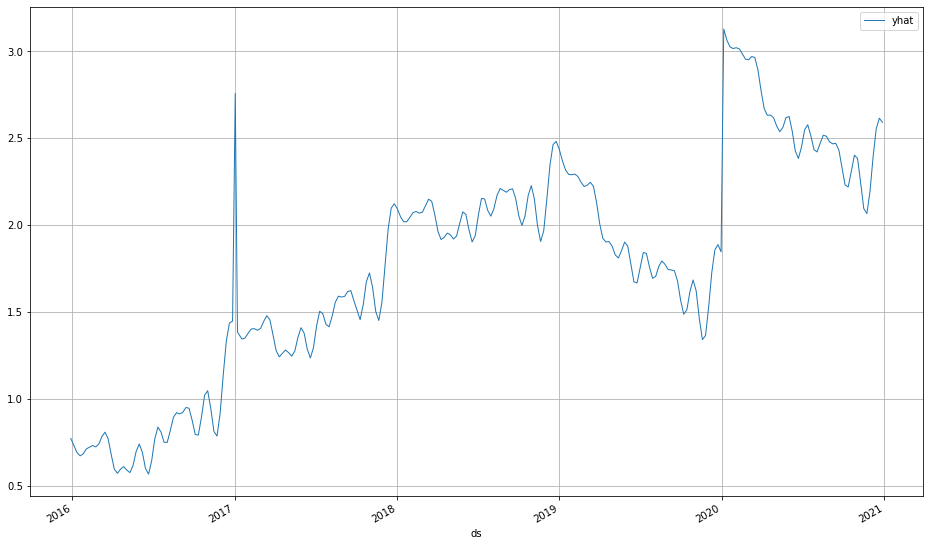

In [26]:
# INITIALIZE FIG DIMENSION AND AXES OBJECTS
fig, axs = plt.subplots(figsize=(16,10))

# ASSIGN AXES OBJECTS ACCORDINGLY
forecast_sample.plot(ax=axs, x='ds', y='yhat', grid=True, label="yhat", linewidth=1)

plt.show()

연 주기로 가격 변동이 나타나는 양상을 보인다.

연초에는 하락세, 연말에는 급상승이 발생함을 관측가능. 상대적으로 12~1월에 높은 가격이 나타난다.

## 평가데이터 불러오기

In [27]:
valid=pd.read_excel('valid_data.xlsx')
print(valid.shape)
valid.head()

(9479, 10)


,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE
0,2020-01-06,수산물,호주,일본,판매용,어류,참치 새치류,남방참다랑어,"냉동,목살",4.883410
1,2020-01-06,수산물,칠레,일본,자사제품제조용,어류,연어,은연어,냉동,5.391782
2,2020-01-06,수산물,중국,중국,판매용,어류,도다리,강도다리,활,6.764961
3,2020-01-06,수산물,중국,중국,판매용,어류,복어,자주복,활,18.499875
4,2020-01-06,수산물,중국,중국,판매용,어류,복어,은밀복,냉동,3.071645


In [28]:
# train data와 마찬가지로 필요한 데이터만 검증하기위해 추출한다
valid1=valid[valid.P_NAME=='오징어'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]
print(valid1.shape)
valid1.head()

(621, 6)


,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
15,2020-01-06,중국,중국,판매용,"냉동,슬라이스(S)",2.706303
16,2020-01-06,중국,중국,판매용,"냉동,다리",1.940000
39,2020-01-06,페루,칠레,판매용,"냉동,동체",2.195883
40,2020-01-06,페루,칠레,판매용,"냉동,지느러미",1.922647
41,2020-01-06,페루,페루,판매용,"냉동,다리",2.855495


In [29]:
sample=valid1[(valid1['CTRY_1']=='중국') & (valid1['CTRY_2']=='중국') & (valid1['P_PURPOSE']=='판매용') & (valid1['P_IMPORT_TYPE']=='냉동')]
sample.reset_index(inplace=True)
sample.drop(columns='index', inplace=True)
print(sample.shape)
sample.tail()

(51, 6)


,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
46,2020-11-30,중국,중국,판매용,냉동,3.255586
47,2020-12-07,중국,중국,판매용,냉동,3.185604
48,2020-12-14,중국,중국,판매용,냉동,3.152568
49,2020-12-21,중국,중국,판매용,냉동,3.444083
50,2020-12-28,중국,중국,판매용,냉동,3.150000


In [30]:
forecast_sample[['ds', 'yhat']].tail(10)

,ds,yhat
250,2020-10-26,2.401150
251,2020-11-02,2.383240
252,2020-11-09,2.243882
253,2020-11-16,2.094457
254,2020-11-23,2.065574
255,2020-11-30,2.191147
256,2020-12-07,2.390968
257,2020-12-14,2.551889
258,2020-12-21,2.614516
259,2020-12-28,2.591131


- 자율평가데이터에서 필요한 데이터로만 만든 Dataframe: sample
- 모델 학습을 통해 예측한 수입가격 Dataframe: forecast_sample
> 두 Dataframe을 merge - 모델 성능평가로 활용

In [31]:
forecast_sample=forecast_sample[['ds','yhat']]
forecast_sample.rename(columns={'ds':'REG_DATE', 'yhat':'PRED_PRICE'}, inplace=True)

In [32]:
# 두개의 Dataframe을 공통되는 REG_DATE에 대해서만 병합. 나머지 row는 drop

In [34]:
pred_sample=forecast_sample.tail(N)
pred_sample.reset_index(inplace=True)
pred_sample.drop(columns='index', inplace=True)
print(pred_sample.shape)
pred_sample.head(10)

(52, 2)


,REG_DATE,PRED_PRICE
0,2020-01-06,3.127257
1,2020-01-13,3.063832
2,2020-01-20,3.024796
3,2020-01-27,3.015054
4,2020-02-03,3.019908
5,2020-02-10,3.013296
6,2020-02-17,2.984328
7,2020-02-24,2.953645
8,2020-03-02,2.950414
9,2020-03-09,2.969398


In [35]:
# REG_DATE(weekly)에 대한 P_PRICE(자율평가데이터의 수입가격), PRED_PRICE(예측모델이 산출한 수입가격)
result=pd.merge(sample[['REG_DATE','P_PRICE']], pred_sample, on='REG_DATE')
result.tail()

,REG_DATE,P_PRICE,PRED_PRICE
46,2020-11-30,3.255586,2.191147
47,2020-12-07,3.185604,2.390968
48,2020-12-14,3.152568,2.551889
49,2020-12-21,3.444083,2.614516
50,2020-12-28,3.150000,2.591131


--------------------------------------------------
### 최종 결과 엑셀 파일로 저장

In [36]:
result.to_excel('result.xlsx')

-----------------------------------------------------------------------

# 모델성능평가 & 결과데이터 시각화

성능평가를 위해 결과 Dataframe 불러오기

In [37]:
result=pd.read_excel('result.xlsx', index_col=0)
print(result.shape)
result.tail()

(51, 3)


,REG_DATE,P_PRICE,PRED_PRICE
46,2020-11-30,3.255586,2.191147
47,2020-12-07,3.185604,2.390968
48,2020-12-14,3.152568,2.551889
49,2020-12-21,3.444083,2.614516
50,2020-12-28,3.150000,2.591131


In [38]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(result['P_PRICE'], result['PRED_PRICE']))

print('평균 제곱근 오차(Root Mean Square Error)는 {}입니다.'.format(rmse))

평균 제곱근 오차(Root Mean Square Error)는 0.8671865246035594입니다.


In [39]:
# mape 계산을 위해 함수생성
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mean_absolute_percentage_error(y_true=result['P_PRICE'], y_pred=result['PRED_PRICE'])

25.592157303878015

- RMSE = 0.867
- MAPE 25.6%로 모델 성능이 74.4%정도 나온다고 판단가능.

In [41]:
pred_sample

,REG_DATE,PRED_PRICE
0,2020-01-06,3.127257
1,2020-01-13,3.063832
2,2020-01-20,3.024796
3,2020-01-27,3.015054
4,2020-02-03,3.019908
5,2020-02-10,3.013296
6,2020-02-17,2.984328
7,2020-02-24,2.953645
8,2020-03-02,2.950414
9,2020-03-09,2.969398


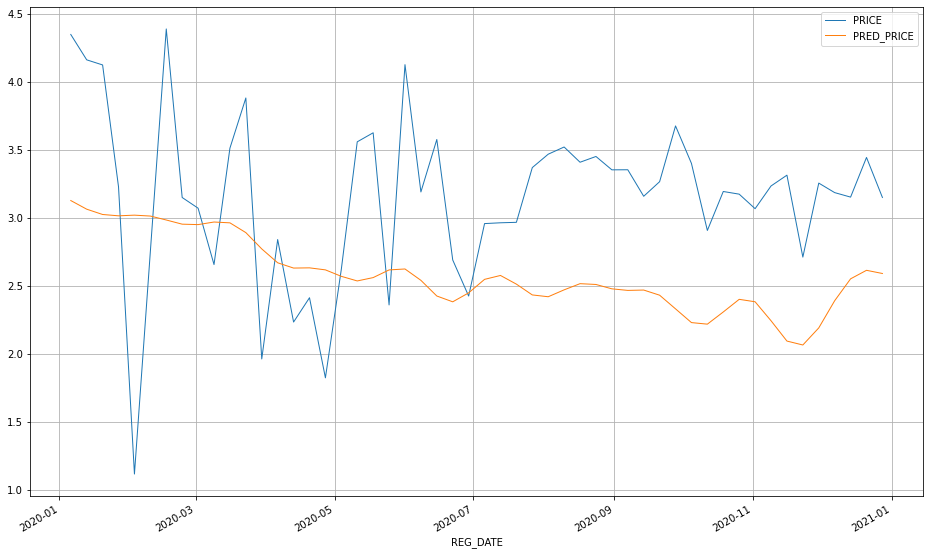

In [42]:
# 실제 데이터와 예측 데이터의 시각화

# INITIALIZE FIG DIMENSION AND AXES OBJECTS
fig, axs = plt.subplots(figsize=(16,10))

# ASSIGN AXES OBJECTS ACCORDINGLY
sample.plot(ax=axs, x='REG_DATE', y='P_PRICE', grid=True, label="PRICE", linewidth=1)
pred_sample.plot(ax=axs, x='REG_DATE', y='PRED_PRICE', grid=True, label="PRED_PRICE", linewidth=1)


plt.show()